In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn as nn


/Users/sujaykumar/Desktop/capstone/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class VannilaGCN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, task = 'node'):
        super(VannilaGCN,self).__init__()

        self.gcn1 = pyg_nn.GCNConv(input_dim,hidden_dim)

        self.lin1 = nn.Linear(hidden_dim,hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self,x,A):
        
        z_latent = self.gcn1(x,A)

        out = self.lin1(z_latent)
        out = self.relu(out)
        
        out = self.lin2(out)
        out = self.sigmoid(out)
        
        return out



In [28]:
class GNNStack(nn.Module):
    """
        Stack of Graph Convolutional models (GCNs)
        
    """

    def __init__(self,input_dim, hidden_dim, output_dim, task='node'):
       
        super(GNNStack,self).__init__()
        self.task = task # Node , Graph Classification

        self.gcn_layers  = nn.ModuleList()
        self.gcn_layers.append(self.build_conv(input_dim=input_dim,hidden_dim=hidden_dim))
        self.gcn_layers.append(self.build_conv(input_dim=hidden_dim, hidden_dim=hidden_dim))
        self.gcn_layers.append(self.build_conv(input_dim=hidden_dim, hidden_dim=hidden_dim))


        self.num_layers = len(self.gcn_layers)

        self.lin1 = nn.Linear(hidden_dim,hidden_dim)
        self.lin2 = nn.Linear(hidden_dim,output_dim)

        self.relu = nn.ReLU()
        
    
    def build_conv(self, input_dim, hidden_dim):
        if self.task == "node":
            return pyg_nn.GCNConv(input_dim,hidden_dim)
        else:
            return pyg_nn.GINConv(
                nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, hidden_dim))
                )

    
    def forward(self,data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for i in range(self.num_layers):
            x = self.gcn_layers[i](x,edge_index)
            x = self.relu(x)
        embedding = x
        
        if self.task == "graph":
            x = pyg_nn.global_mean_pool(x,batch)
        
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        return embedding, x
    
GNNStack(256,128,1) 



GNNStack(
  (gcn_layers): ModuleList(
    (0): GCNConv(256, 128)
    (1-2): 2 x GCNConv(128, 128)
  )
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [7]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()

        self.convs.append(self.build_conv_model(input_dim, hidden_dim))

        self.lns = nn.ModuleList()
        
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))

        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25),
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)


    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [52]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/citeseer', name='citeseer')
task = 'node'


In [53]:
test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)


model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [54]:
sample = []
for i in loader:
    sample.append(i)
print(sample[0])
len(sample)


DataBatch(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], batch=[3327], ptr=[2])


1

In [60]:
NUM_EPOCHS = 200
for epoch in range(NUM_EPOCHS):
    tot_loss = 0.0
    model.train()
    for batch in loader:
        opt.zero_grad()
        _, logits = model(batch)
        label = batch.y
        # pred = logits[batch.train_mask]
        # label = label[batch.train_mask]
        loss = loss_fn(logits,label)
        loss.backward()
        opt.step()
        tot_loss += loss.item() * batch.num_graphs
    tot_loss /= len(loader.dataset)
    print(f"Epoch [{epoch+1}]/[{NUM_EPOCHS}] the loss is {tot_loss}")




Epoch [1]/[200] the loss is 0.12121108919382095
Epoch [2]/[200] the loss is 0.1788460910320282
Epoch [3]/[200] the loss is 0.11436241120100021
Epoch [4]/[200] the loss is 0.14670653641223907
Epoch [5]/[200] the loss is 0.12396319955587387
Epoch [6]/[200] the loss is 0.13151969015598297
Epoch [7]/[200] the loss is 0.123564712703228
Epoch [8]/[200] the loss is 0.12390391528606415
Epoch [9]/[200] the loss is 0.11719194799661636
Epoch [10]/[200] the loss is 0.11943270266056061
Epoch [11]/[200] the loss is 0.11547110974788666
Epoch [12]/[200] the loss is 0.1123054027557373
Epoch [13]/[200] the loss is 0.11321038007736206
Epoch [14]/[200] the loss is 0.1066887304186821
Epoch [15]/[200] the loss is 0.10947078466415405
Epoch [16]/[200] the loss is 0.10407425463199615
Epoch [17]/[200] the loss is 0.1071038469672203
Epoch [18]/[200] the loss is 0.10112284123897552
Epoch [19]/[200] the loss is 0.10315719246864319
Epoch [20]/[200] the loss is 0.09984998404979706
Epoch [21]/[200] the loss is 0.0993

/Users/sujaykumar/Desktop/capstone/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


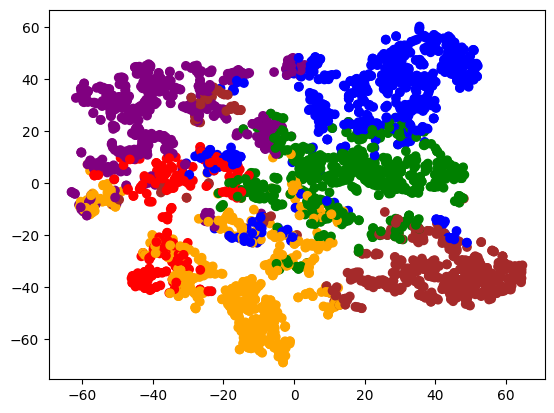

In [61]:
color_list = ["red", "orange", "green", "blue", "purple", "brown"]
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/citeseer', name='citeseer')
task = 'node'
loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)